In [1]:
import torch
from torch import nn
from torch import optim

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from tqdm import tqdm

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np
import random
import timeit
import pandas as pd
import pickle
import warnings

from pandas.errors import PerformanceWarning

In [2]:
random_seed = 47
batch_size = 512
epochs = 40

learning_rate = 1e-4
num_classes = 10
patch_size = 4
img_size = 32
in_channels = 3
num_heads = 8
dropout = 0.001
hidden_dim = 768
adam_weight_decay = 0
adam_betas = (0.9, 0.999)
activation = "gelu"
num_encoders = 4
embed_dim = (patch_size ** 2) * in_channels # 48
num_patches = (img_size / patch_size) ** 2 # 49

random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda:0" if torch.cuda.is_available() else "cpu"

print(embed_dim)
print(num_patches)

48
64.0


In [3]:
warnings.filterwarnings("ignore", category=PerformanceWarning)

In [4]:
## Limit device memory usage
## https://stackoverflow.com/questions/49529372/force-gpu-memory-limit-in-pytorch
# torch.cuda.empty_cache()

In [5]:
class PatchEmbedding(nn.Module):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels):
        super().__init__()
        
        self.patcher = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=embed_dim,
                kernel_size=patch_size,
                stride=patch_size
            ),
            nn.Flatten(2)
        )
        
        self.cls_token = nn.Parameter(torch.randn(size=(1, in_channels, embed_dim)), requires_grad=True)
        self.position_embeddings = nn.Parameter(torch.randn(size=(1, int(num_patches + in_channels), embed_dim)), requires_grad=True)
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, x):
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        
        x = self.patcher(x).permute(0, 2, 1)
        x = torch.cat([cls_token, x], dim=1)
        x = self.position_embeddings + x
        x = self.dropout(x)
        
        return x

# dTypes with data must be GPU related. so specifying device in some areas may solve issues.
model = PatchEmbedding(embed_dim, patch_size, num_patches, dropout, in_channels).to(device)
x = torch.randn((batch_size, in_channels, img_size, img_size)).to(device)

print(model(x).shape)
# 512 - bag size
# 50 - num of tokens to fit (Number of patches + cls_token)
# 48 - the size of the patches (divided by 3 because rgb layers)

torch.Size([512, 67, 48])


In [6]:
class ViT(nn.Module):
    def __init__(self, num_patches, num_classes, patch_size, embed_dim, num_encoders, num_heads, hidden_dim, dropout, activation, in_channels):
        super().__init__()
        self.embeddings_block = PatchEmbedding(embed_dim, patch_size, num_patches, dropout, in_channels)
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout, activation=activation, batch_first=True, norm_first=True)
        self.encoder_blocks = nn.TransformerEncoder(encoder_layer, num_layers=num_encoders)
        
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embed_dim),
            nn.Linear(in_features=embed_dim, out_features=num_classes)
        )
        
    def forward(self, x):
        x = self.embeddings_block(x)
        x = self.encoder_blocks(x)
        x = self.mlp_head(x[:, 0, :])
        return x
        

In [7]:
model = ViT(num_patches, num_classes, patch_size, embed_dim, num_encoders, num_heads, hidden_dim, dropout, activation, in_channels).to(device)
x = torch.randn((batch_size, in_channels, img_size, img_size)).to(device)
print(model(x).shape)

torch.Size([512, 10])


c:\Users\tomsr\Documents\School\aidi\AIDI1002 - Machine Learning Programming\week-12\.final\Lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


## Load Meta Data

`num_cases_per_batch`, </br>
`label_names`, </br>
`num_vis` </br>

In [8]:
cifar_meta_file = open("./cifar-10-python/cifar-10-batches-py/batches.meta", "rb")
cifar_meta_obj = pickle.load(cifar_meta_file, encoding="bytes")

## Load Data

In [9]:
# cifar_dataset = CIFAR10(root='./data', download=True)
cifar_data_file = open("./cifar-10-python/cifar-10-batches-py/data_batch_1", "rb")

def cifar_batch_to_df(file, meta):
    obj = pickle.load(file, encoding="bytes")
    file.close()
    
    data = obj[b"data"]
    labels = obj[b"labels"]
    filenames = obj[b"filenames"]
    categories = [meta[b"label_names"][label] for label in labels]
 
    df = pd.DataFrame(data, columns=[f"pixel{x}" for x in range(len(data[0]))])
    df.insert(loc=0, column="label", value=labels)
    df.insert(loc=1, column="filename", value=filenames)
    df.insert(loc=2, column="category", value=categories)

    return df
    
cifar_training_df = cifar_batch_to_df(cifar_data_file, cifar_meta_obj)

cifar_training_df.head(5)

,label,filename,category,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,...,pixel3062,pixel3063,pixel3064,pixel3065,pixel3066,pixel3067,pixel3068,pixel3069,pixel3070,pixel3071
0,6,b'leptodactylus_pentadactylus_s_000004.png',b'frog',59,43,50,68,98,119,139,...,59,58,65,59,46,57,104,140,84,72
1,9,b'camion_s_000148.png',b'truck',154,126,105,102,125,155,172,...,22,42,67,101,122,133,136,139,142,144
2,9,b'tipper_truck_s_001250.png',b'truck',255,253,253,253,253,253,253,...,78,83,80,69,66,72,79,83,83,84
3,4,b'american_elk_s_001521.png',b'deer',28,37,38,42,44,40,40,...,53,39,59,42,44,48,38,28,37,46
4,1,b'station_wagon_s_000293.png',b'automobile',170,168,177,183,181,177,181,...,92,88,85,82,83,79,78,82,78,80


In [10]:
cifar_test_file = open("./cifar-10-python/cifar-10-batches-py/test_batch", "rb")

cifar_test_df = cifar_batch_to_df(cifar_test_file, cifar_meta_obj)

cifar_test_df.tail(5)

,label,filename,category,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,...,pixel3062,pixel3063,pixel3064,pixel3065,pixel3066,pixel3067,pixel3068,pixel3069,pixel3070,pixel3071
9995,8,b'cabin_cruiser_s_000783.png',b'ship',76,76,77,76,75,76,76,...,228,185,177,223,239,239,235,236,234,236
9996,3,b'tabby_cat_s_000494.png',b'cat',81,91,98,106,108,110,80,...,126,107,143,155,156,160,173,129,147,160
9997,5,b'pekinese_s_002005.png',b'dog',20,19,15,15,14,13,12,...,114,112,68,50,52,52,51,50,53,47
9998,1,b'convertible_s_002525.png',b'automobile',25,15,23,17,23,51,74,...,87,84,83,84,79,78,78,80,81,80
9999,7,b'broodmare_s_000763.png',b'horse',73,98,99,77,59,146,214,...,84,89,88,85,93,93,90,94,58,26


## Convert DF data into image and show

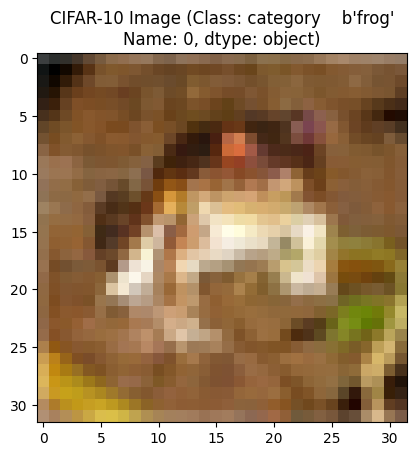

In [11]:
# Recreate the bytes object from the bytearray
img_bytes = np.array([*cifar_training_df.iloc[0, 3:]])
label = cifar_training_df.iloc[0, 2:3]

reconstructed_img = img_bytes.reshape(3, 32, 32)
permuted_image = reconstructed_img.transpose(1, 2, 0)

plt.imshow(permuted_image)
plt.title(f'CIFAR-10 Image (Class: {label})')
plt.show()

In [12]:
X = cifar_training_df.iloc[:, 3:]
y = cifar_training_df.iloc[:, :1]

X_test = cifar_test_df.iloc[:1000, 3:]
y_test = cifar_test_df.iloc[:1000, :1]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

X
X_test

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel3062,pixel3063,pixel3064,pixel3065,pixel3066,pixel3067,pixel3068,pixel3069,pixel3070,pixel3071
0,158,159,165,166,160,156,162,159,158,159,...,130,123,145,167,182,175,145,124,129,110
1,235,231,232,232,232,232,232,232,232,232,...,108,117,123,133,141,153,163,178,191,199
2,158,158,139,132,166,182,187,193,199,205,...,45,46,44,44,43,52,37,8,3,7
3,155,167,176,190,177,166,168,166,170,179,...,52,55,70,103,105,72,53,50,52,50
4,65,70,48,30,23,40,44,45,45,40,...,102,127,156,139,131,130,147,136,146,117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,184,196,187,182,198,206,214,215,211,211,...,134,130,171,128,100,159,157,101,65,102
996,141,150,159,159,132,135,165,162,174,184,...,40,35,29,41,75,69,79,94,74,121
997,103,124,73,99,143,152,153,151,172,249,...,38,37,38,43,44,46,49,53,50,37
998,77,72,76,72,79,75,57,62,94,107,...,64,53,45,47,43,49,71,47,22,30


In [13]:
class ImageShapeTransformer():
    def __init__(self, in_channels=3, height=32, width=32):
        self.in_channels = in_channels
        self.height = height
        self.width = width
        
    def __call__(self, img):
        return np.array(img).reshape(self.in_channels, self.height, self.width).transpose(1, 2, 0)

class MNISTTrainDataset(Dataset):
    def __init__(self, images, labels, indices) -> None:
        super().__init__()
        
        print(f"Adding {len(images)} to images")
        self.images = images
        print(f"Adding {len(labels)} to labels")
        self.labels = labels
        print(f"Adding {len(indices)} to indices")
        self.indices = indices
        
        self.transform = transforms.Compose([
            ImageShapeTransformer(),
            
            transforms.ToTensor(),
            
            transforms.RandomRotation(15),
            transforms.Normalize([0.5], [0.5]),
        ])
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        
        image = self.images.iloc[index]
        label = self.labels[index]
        index = self.indices[index]
        image = self.transform(image)
        
        return { 
                'image': image, 
                'label': label, 
                'index': index,
            } 
    
class MNISTValDataset(Dataset):
    def __init__(self, images, labels, indices) -> None:
        super().__init__()
        self.images = images
        self.labels = labels
        self.indices = indices
        self.transform = transforms.Compose([
            ImageShapeTransformer(),
            
            transforms.ToTensor(), 
            transforms.Normalize([0.5], [0.5]),
        ])
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = self.images.iloc[index]
        label = self.labels[index]
        index = self.indices[index]
        image = self.transform(image)
        
        return { 'image': image, 'label': label, 'index': index }  
    
class MNISTTestDataset(Dataset):
    def __init__(self, images, indices) -> None:
        super().__init__()
        self.images = images
        self.indices = indices
        self.transform = transforms.Compose([
            ImageShapeTransformer(),
            
            transforms.ToTensor(),   
            transforms.Normalize([0.5], [0.5]),
        ])
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = self.images.iloc[index]
        index = self.indices[index]
        image = self.transform(image)
        
        return { 'image': image, 'index': index } 

## Dataset Tests

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Adding 8000 to images
Adding 8000 to labels
Adding 8000 to indices


<Figure size 640x480 with 0 Axes>

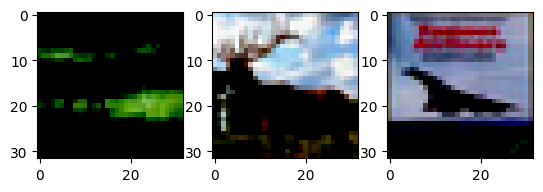

In [14]:
plt.figure()
f, ax = plt.subplots(1, 3)

train_dataset = MNISTTrainDataset(X_train, y_train.values, X_train.index.values)
val_dataset = MNISTValDataset(X_val, y_val.values, X_val.index.values)
test_dataset = MNISTTestDataset(X_test, X_test.index.values)

ax[0].imshow(train_dataset[3]['image'].permute(1, 2, 0).numpy())
ax[1].imshow(val_dataset[3]['image'].permute(1, 2, 0).numpy())
ax[2].imshow(test_dataset[3]['image'].permute(1, 2, 0).numpy())
plt.show()

In [15]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)
val_dataloader = DataLoader(dataset=val_dataset,
                            batch_size=batch_size,
                            shuffle=True)


In [16]:
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), betas=adam_betas, lr=learning_rate, weight_decay=adam_weight_decay)

start = timeit.default_timer()
for epoch in tqdm(range(epochs), position=0, leave=True):
    model.train()
    train_labels = []
    train_preds = []
    train_running_loss = 0
    
    for idx, img_label in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        
        img = img_label["image"].float().to(device)
        label = img_label["label"].type(torch.long).squeeze(dim=1).to(device)
        
        y_pred = model(img)
        y_pred_label = torch.argmax(y_pred, dim=1)
        
        train_labels.extend(label.cpu().detach())
        train_preds.extend(y_pred_label.cpu().detach())
        
        loss = criterion(y_pred, label)
        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()
        
        train_running_loss += loss.item()
        
    train_loss = train_running_loss / (idx + 1)

    model.eval()
    val_labels = []
    val_preds = []
    val_running_loss = 0
    
    with torch.no_grad():
        for idx, img_label in enumerate(tqdm(val_dataloader, position=0, leave=True)):
            img = img_label["image"].float().to(device)
            label = img_label["label"].type(torch.uint8).squeeze(dim=1).to(device)         
            y_pred = model(img)
            y_pred_label = torch.argmax(y_pred, dim=1)
            
            val_labels.extend(label.cpu().detach())
            val_preds.extend(y_pred_label.cpu().detach())
            
            loss = criterion(y_pred, label)
            val_running_loss += loss.item()
    val_loss = val_running_loss / (idx + 1)

    print("-"*30)
    print(f"Train Loss EPOCH {epoch+1}: {train_loss:.4f}")
    print(f"Valid Loss EPOCH {epoch+1}: {val_loss:.4f}")
    print(f"Train Accuracy EPOCH {epoch+1}: {sum(1 for x,y in zip(train_preds, train_labels) if x == y) / len(train_labels):.4f}")
    print(f"Valid Accuracy EPOCH {epoch+1}: {sum(1 for x,y in zip(val_preds, val_labels) if x == y) / len(val_labels):.4f}")
    print("-"*30)

stop = timeit.default_timer()
print(f"Training Time: {stop-start:.2f}s")

  2%|▎         | 1/40 [00:07<04:50,  7.44s/it]

------------------------------
Train Loss EPOCH 1: 2.3289
Valid Loss EPOCH 1: 2.2915
Train Accuracy EPOCH 1: 0.1105
Valid Accuracy EPOCH 1: 0.1290
------------------------------


  5%|▌         | 2/40 [00:14<04:33,  7.20s/it]

------------------------------
Train Loss EPOCH 2: 2.2715
Valid Loss EPOCH 2: 2.2529
Train Accuracy EPOCH 2: 0.1464
Valid Accuracy EPOCH 2: 0.1690
------------------------------


  8%|▊         | 3/40 [00:21<04:22,  7.09s/it]

------------------------------
Train Loss EPOCH 3: 2.2241
Valid Loss EPOCH 3: 2.1944
Train Accuracy EPOCH 3: 0.1735
Valid Accuracy EPOCH 3: 0.1905
------------------------------


 10%|█         | 4/40 [00:28<04:15,  7.10s/it]

------------------------------
Train Loss EPOCH 4: 2.1373
Valid Loss EPOCH 4: 2.0870
Train Accuracy EPOCH 4: 0.2090
Valid Accuracy EPOCH 4: 0.2390
------------------------------


 12%|█▎        | 5/40 [00:35<04:07,  7.07s/it]

------------------------------
Train Loss EPOCH 5: 2.0454
Valid Loss EPOCH 5: 1.9908
Train Accuracy EPOCH 5: 0.2301
Valid Accuracy EPOCH 5: 0.2620
------------------------------


 15%|█▌        | 6/40 [00:42<04:00,  7.08s/it]

------------------------------
Train Loss EPOCH 6: 1.9922
Valid Loss EPOCH 6: 1.9551
Train Accuracy EPOCH 6: 0.2599
Valid Accuracy EPOCH 6: 0.2720
------------------------------


 18%|█▊        | 7/40 [00:49<03:54,  7.09s/it]

------------------------------
Train Loss EPOCH 7: 1.9592
Valid Loss EPOCH 7: 1.9341
Train Accuracy EPOCH 7: 0.2729
Valid Accuracy EPOCH 7: 0.2865
------------------------------


 20%|██        | 8/40 [00:57<03:49,  7.16s/it]

------------------------------
Train Loss EPOCH 8: 1.9391
Valid Loss EPOCH 8: 1.9183
Train Accuracy EPOCH 8: 0.2786
Valid Accuracy EPOCH 8: 0.2950
------------------------------


 22%|██▎       | 9/40 [01:04<03:46,  7.31s/it]

------------------------------
Train Loss EPOCH 9: 1.9104
Valid Loss EPOCH 9: 1.8963
Train Accuracy EPOCH 9: 0.2923
Valid Accuracy EPOCH 9: 0.3040
------------------------------


 25%|██▌       | 10/40 [01:11<03:38,  7.27s/it]

------------------------------
Train Loss EPOCH 10: 1.9004
Valid Loss EPOCH 10: 1.8834
Train Accuracy EPOCH 10: 0.3000
Valid Accuracy EPOCH 10: 0.3090
------------------------------


 28%|██▊       | 11/40 [01:19<03:30,  7.24s/it]

------------------------------
Train Loss EPOCH 11: 1.8908
Valid Loss EPOCH 11: 1.8728
Train Accuracy EPOCH 11: 0.2993
Valid Accuracy EPOCH 11: 0.3235
------------------------------


 30%|███       | 12/40 [01:26<03:22,  7.24s/it]

------------------------------
Train Loss EPOCH 12: 1.8804
Valid Loss EPOCH 12: 1.8596
Train Accuracy EPOCH 12: 0.3053
Valid Accuracy EPOCH 12: 0.3255
------------------------------


 32%|███▎      | 13/40 [01:33<03:13,  7.16s/it]

------------------------------
Train Loss EPOCH 13: 1.8625
Valid Loss EPOCH 13: 1.8425
Train Accuracy EPOCH 13: 0.3232
Valid Accuracy EPOCH 13: 0.3400
------------------------------


 35%|███▌      | 14/40 [01:40<03:07,  7.23s/it]

------------------------------
Train Loss EPOCH 14: 1.8410
Valid Loss EPOCH 14: 1.8316
Train Accuracy EPOCH 14: 0.3281
Valid Accuracy EPOCH 14: 0.3405
------------------------------


 38%|███▊      | 15/40 [01:47<03:01,  7.24s/it]

------------------------------
Train Loss EPOCH 15: 1.8272
Valid Loss EPOCH 15: 1.8299
Train Accuracy EPOCH 15: 0.3340
Valid Accuracy EPOCH 15: 0.3365
------------------------------


 40%|████      | 16/40 [01:55<02:54,  7.25s/it]

------------------------------
Train Loss EPOCH 16: 1.8098
Valid Loss EPOCH 16: 1.7968
Train Accuracy EPOCH 16: 0.3475
Valid Accuracy EPOCH 16: 0.3510
------------------------------


 42%|████▎     | 17/40 [02:02<02:46,  7.23s/it]

------------------------------
Train Loss EPOCH 17: 1.7892
Valid Loss EPOCH 17: 1.7750
Train Accuracy EPOCH 17: 0.3453
Valid Accuracy EPOCH 17: 0.3530
------------------------------


 45%|████▌     | 18/40 [02:09<02:39,  7.27s/it]

------------------------------
Train Loss EPOCH 18: 1.7858
Valid Loss EPOCH 18: 1.7537
Train Accuracy EPOCH 18: 0.3496
Valid Accuracy EPOCH 18: 0.3650
------------------------------


 48%|████▊     | 19/40 [02:17<02:34,  7.36s/it]

------------------------------
Train Loss EPOCH 19: 1.7610
Valid Loss EPOCH 19: 1.7528
Train Accuracy EPOCH 19: 0.3558
Valid Accuracy EPOCH 19: 0.3595
------------------------------


 50%|█████     | 20/40 [02:25<02:29,  7.47s/it]

------------------------------
Train Loss EPOCH 20: 1.7428
Valid Loss EPOCH 20: 1.7591
Train Accuracy EPOCH 20: 0.3700
Valid Accuracy EPOCH 20: 0.3640
------------------------------


 52%|█████▎    | 21/40 [02:32<02:22,  7.49s/it]

------------------------------
Train Loss EPOCH 21: 1.7324
Valid Loss EPOCH 21: 1.7234
Train Accuracy EPOCH 21: 0.3700
Valid Accuracy EPOCH 21: 0.3755
------------------------------


 55%|█████▌    | 22/40 [02:39<02:13,  7.42s/it]

------------------------------
Train Loss EPOCH 22: 1.7125
Valid Loss EPOCH 22: 1.7075
Train Accuracy EPOCH 22: 0.3782
Valid Accuracy EPOCH 22: 0.3915
------------------------------


 57%|█████▊    | 23/40 [02:46<02:04,  7.33s/it]

------------------------------
Train Loss EPOCH 23: 1.7039
Valid Loss EPOCH 23: 1.7218
Train Accuracy EPOCH 23: 0.3822
Valid Accuracy EPOCH 23: 0.3770
------------------------------


 60%|██████    | 24/40 [02:54<01:58,  7.40s/it]

------------------------------
Train Loss EPOCH 24: 1.6820
Valid Loss EPOCH 24: 1.6998
Train Accuracy EPOCH 24: 0.3997
Valid Accuracy EPOCH 24: 0.3935
------------------------------


 62%|██████▎   | 25/40 [03:01<01:50,  7.35s/it]

------------------------------
Train Loss EPOCH 25: 1.6728
Valid Loss EPOCH 25: 1.6870
Train Accuracy EPOCH 25: 0.3967
Valid Accuracy EPOCH 25: 0.3885
------------------------------


 65%|██████▌   | 26/40 [03:08<01:41,  7.26s/it]

------------------------------
Train Loss EPOCH 26: 1.6548
Valid Loss EPOCH 26: 1.6819
Train Accuracy EPOCH 26: 0.4021
Valid Accuracy EPOCH 26: 0.3860
------------------------------


 68%|██████▊   | 27/40 [03:16<01:34,  7.24s/it]

------------------------------
Train Loss EPOCH 27: 1.6547
Valid Loss EPOCH 27: 1.6771
Train Accuracy EPOCH 27: 0.3992
Valid Accuracy EPOCH 27: 0.4020
------------------------------


 70%|███████   | 28/40 [03:23<01:26,  7.24s/it]

------------------------------
Train Loss EPOCH 28: 1.6317
Valid Loss EPOCH 28: 1.6534
Train Accuracy EPOCH 28: 0.4130
Valid Accuracy EPOCH 28: 0.4045
------------------------------


 72%|███████▎  | 29/40 [03:30<01:19,  7.24s/it]

------------------------------
Train Loss EPOCH 29: 1.6274
Valid Loss EPOCH 29: 1.6352
Train Accuracy EPOCH 29: 0.4103
Valid Accuracy EPOCH 29: 0.4080
------------------------------


 75%|███████▌  | 30/40 [03:37<01:11,  7.17s/it]

------------------------------
Train Loss EPOCH 30: 1.6046
Valid Loss EPOCH 30: 1.6441
Train Accuracy EPOCH 30: 0.4190
Valid Accuracy EPOCH 30: 0.4060
------------------------------


 78%|███████▊  | 31/40 [03:44<01:04,  7.12s/it]

------------------------------
Train Loss EPOCH 31: 1.6096
Valid Loss EPOCH 31: 1.6487
Train Accuracy EPOCH 31: 0.4143
Valid Accuracy EPOCH 31: 0.4025
------------------------------


 80%|████████  | 32/40 [03:51<00:57,  7.15s/it]

------------------------------
Train Loss EPOCH 32: 1.5915
Valid Loss EPOCH 32: 1.6432
Train Accuracy EPOCH 32: 0.4253
Valid Accuracy EPOCH 32: 0.3925
------------------------------


 82%|████████▎ | 33/40 [03:58<00:50,  7.16s/it]

------------------------------
Train Loss EPOCH 33: 1.5810
Valid Loss EPOCH 33: 1.6318
Train Accuracy EPOCH 33: 0.4320
Valid Accuracy EPOCH 33: 0.4105
------------------------------


 85%|████████▌ | 34/40 [04:05<00:42,  7.13s/it]

------------------------------
Train Loss EPOCH 34: 1.5830
Valid Loss EPOCH 34: 1.6150
Train Accuracy EPOCH 34: 0.4243
Valid Accuracy EPOCH 34: 0.4280
------------------------------


 88%|████████▊ | 35/40 [04:13<00:35,  7.13s/it]

------------------------------
Train Loss EPOCH 35: 1.5592
Valid Loss EPOCH 35: 1.5921
Train Accuracy EPOCH 35: 0.4328
Valid Accuracy EPOCH 35: 0.4355
------------------------------


 90%|█████████ | 36/40 [04:20<00:28,  7.14s/it]

------------------------------
Train Loss EPOCH 36: 1.5556
Valid Loss EPOCH 36: 1.5756
Train Accuracy EPOCH 36: 0.4395
Valid Accuracy EPOCH 36: 0.4355
------------------------------


 92%|█████████▎| 37/40 [04:27<00:21,  7.14s/it]

------------------------------
Train Loss EPOCH 37: 1.5463
Valid Loss EPOCH 37: 1.5963
Train Accuracy EPOCH 37: 0.4377
Valid Accuracy EPOCH 37: 0.4240
------------------------------


 95%|█████████▌| 38/40 [04:34<00:14,  7.22s/it]

------------------------------
Train Loss EPOCH 38: 1.5392
Valid Loss EPOCH 38: 1.5704
Train Accuracy EPOCH 38: 0.4444
Valid Accuracy EPOCH 38: 0.4370
------------------------------


 98%|█████████▊| 39/40 [04:42<00:07,  7.32s/it]

------------------------------
Train Loss EPOCH 39: 1.5380
Valid Loss EPOCH 39: 1.5696
Train Accuracy EPOCH 39: 0.4411
Valid Accuracy EPOCH 39: 0.4425
------------------------------


100%|██████████| 40/40 [04:49<00:00,  7.24s/it]

------------------------------
Train Loss EPOCH 40: 1.5152
Valid Loss EPOCH 40: 1.5676
Train Accuracy EPOCH 40: 0.4601
Valid Accuracy EPOCH 40: 0.4460
------------------------------
Training Time: 289.72s
